################################################################

version info

- 23df010 - before peppering version all over the places in benchmarking 
- f185856 - commit before messing with parfor 2020.0919 bof
- 0c2522d - timestamping info for benchmark
- 1cfc17c - add SNOW package, tweaked timestamping

- 1799ba4 - 2020.0927 forked to jupyter_R_DIOS_demo_par.ipynb - play with mcparallel for SimAnneal
- 104ac77 - some clean up, restore to run with orig simulation param 100/30//1000 (all cores) - plan benchmark next

################################################################

version on bfh, 
prev save: 2020.0910 ; keep this one for now ; has some benchmark info
but starting to also put info in benchmark_note.rst (for things run directly by R)

## bof     20min per chain. Total 52m    --  30/10//3 n.total/n.initial//n.real (15 thread)

last saved 2020.0919 - before start messing with %parfor% -- f185856


################################################################

conversion:
singularity exec DIOS_demonstration_latest.sif /opt/conda/bin/jupyter nbconvert --to python jupyter_R_DIOS_demo.ipynb
singularity exec DIOS_demonstration_latest.sif /usr/bin/Rscript  ./jupyter_R_DIOS_demo.py  2>&1 | tee output.n0170.0919.1701.log.rst

################################################################

# DIOS_demonstration.R, 
## Converted into jupyter notebook

Preprint paper location: http://tbd 

####

Loading this jupyter notebook via singularity container:
```
singularity pull shub://tin6150/DIOS_demonstration
singularity exec DIOS_demonstration_latest.sif /opt/conda/bin/jupyter lab
```
then point your browser to the URL displayed, eg
http://localhost:8888/lab


In [1]:
print('##--begin--## the beginning ##--begin--##') 
system('id -a; hostname; pwd -P; date', intern=TRUE)
# output in console unless have intern=TRUE

[1] "##--begin--## the beginning ##--begin--##"


[1] "uid=0(root) gid=0(root) groups=0(root)"
[2] "3ff288903d14"                          
[3] "/mnt/code"                             
[4] "Sun 27 Sep 2020 12:35:25 PM PDT"

In [2]:
.libPaths()

[1] "/usr/local/lib/R/site-library" "/usr/lib/R/site-library"      
[3] "/usr/lib/R/library"

In [3]:
# .libPaths( c( .libPaths(), '/home/tin/R/x86_64-pc-linux-gnu-library/3.4' ) )

In [4]:
# install.packages("raster", repos = "http://cran.us.r-project.org")
# raster not avail for R 3.4.4    Mint isn't very up to date with R:-\
library(raster)

Loading required package: sp



In [5]:
.libPaths()

[1] "/usr/local/lib/R/site-library" "/usr/lib/R/site-library"      
[3] "/usr/lib/R/library"

## code from DIOS_demonstration.R follows

In [6]:
library(ggplot2)  
library(raster)   
library(mvnfast)    ## Fast Multivariate Normal and Student's t Methods
library(gstat)      ## Spatial and Spatio-Temporal Geostatistical Modelling, Prediction and Simulation
library(cowplot)  
library(geoR)       ## https://cran.r-project.org/web/packages/geoR/geoR.pdf
library(foreach)    ## Provides Foreach Looping Construct
library(doParallel) ## foreach parallel adapter https://cran.r-project.org/web/packages/doParallel/doParallel.pdf
library(tidyverse)  ## Pandas
library(rPref)      ## Database Preferences and Skyline Computation https://cran.r-project.org/web/packages/rPref/rPref.pdf
library(RColorBrewer)




Warning message:
“no DISPLAY variable so Tk is not available”
--------------------------------------------------------------
 Analysis of Geostatistical Data
 For an Introduction to geoR go to http://www.leg.ufpr.br/geoR
 geoR version 1.8-1 (built on 2020-02-08) is now loaded
--------------------------------------------------------------


Loading required package: iterators

Loading required package: parallel

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::accumulate() masks foreach::accumulate()
✖ tidyr::extract()    masks raster::extract()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ dplyr::select()     masks raster::select()
✖ purrr::when()       masks foreach::when()


Attaching package: ‘

In [7]:
library(data.table)



Attaching package: ‘data.table’


The following object is masked from ‘package:rPref’:

    between


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


The following object is masked from ‘package:raster’:

    shift




In [8]:
source("DIOS_demonstration_functions.R")  
set.seed(123)

In [9]:
#==========================================================
#                Demonstration setting
#==========================================================
#================== Parameters ======================
# parameters for points
##n.total <- 100
##n.initial <- 30

## fixed a few places that hard coded for-loops as 1:70, now can reduce number of sites
## n.total/n.initial/n.candidate 34/10/24 is quick for most things other than SimAnneal, which took 3*15 min
## 10/4 error about phi(range) being 0.  14/6 fails tool.  24/8 fails.  24/10 fails.
## 30/10 works.  Need a ratio of at least 1/3 for phi ~0.3 and higher and models to run?
n.total   <- 100 ##30  ##100 #  
n.initial <- 30  ##10  ## 30 #  # there maybe some places expecting at least 10? 
# don't seems to be able to lower either n.total or n.initial, later code have hard dependencies on these values
n.candidate = n.total - n.initial ## the remaining 70 sites that could be added to the network.  Trying to remove hard coding of 1..70 in code below

# parameters for linear part
beta0 <- 3 - log(100000)
beta1 <- 1

# parameters for spatial correlation
Y.sigmas <- 1             # sigma_s
Y.range <- c(0.1, 0.3)   # rho
Y.sigmad <- 0.1          # sigma_d

# parameters for the risk factor X
sigma <- 0.2


## timing on 32 core no Logical Processor cascadelake 5218@2.3GHz 145sav3 singularity R: 62 => 3h7m. 32 -> 3h11m.  31 => 3h22m. 4 => 6hr. 
## hma 71 min 30/10//3   (A/B/0.1/0.3) 32  => 71min. 16 => 71min (ie no diff).  [Jupyter]
##NumThread = 31 # cant do 128, error about socket 
NumThread = ( 1 * detectCores() - 1 )  ## dont double if Logical Processor is on, 1/2 would actually be better in such case (at least for SimAnneal, but that param set in the function itself for now)
NumThread = ( 1 * detectCores() - 0 )  
# number of realizations of the disease model to generate
n.real <- 1000
#~n.real <- 200  
##//n.real <- 3  
# 32 core cascade lake 5218 2.3 GHz // 58 threads, but load avg peaked at ~9, mostly ~4.  (was actually hard coded to use 4)
# 200/100/30 (n.real/n.total/n.initial) ~3 hours.  100/100/30 ~2hr [singularity R]
#  60/100/30 took ~90min.  
#  20/100/30 ~63min.  
#  10/100/30 ~53min  . 



In [10]:
#=========== generate point locations ================
coord <- data.frame(x = runif(n.total), y = runif(n.total), sampled = 0) # generate n.total random points in the unit grid
sampled.id <- sample(1:n.total, n.initial)   # sample n.initial points from them as the intial design
coord$sampled[sampled.id] <- 1
coord.sampled   <- coord[coord$sampled == 1,]   # initial sites
coord.unsampled <- coord[coord$sampled == 0,] # alternative sites

In [11]:
#=========== generate risk factor X in the unit grid ==================
X.coord <- expand.grid(x = seq(0, 1, 0.01), y = seq(0, 1, 0.01)) # gernerate grid

# location of the two point sources. They are set to be far apart from each other.
center1 <- data.frame(x = 0.82, y = 0.55)
center2 <- data.frame(x = 0.24, y = 0.24)

# generate risk factor level
X.coord$Xvalue <- dnorm(sqrt((X.coord$x - center1$x)^2 + (X.coord$y - center1$y)^2), mean = 0, sd = sigma) + 
                  dnorm(sqrt((X.coord$x - center2$x)^2 + (X.coord$y - center2$y)^2), mean = 0, sd = sigma)


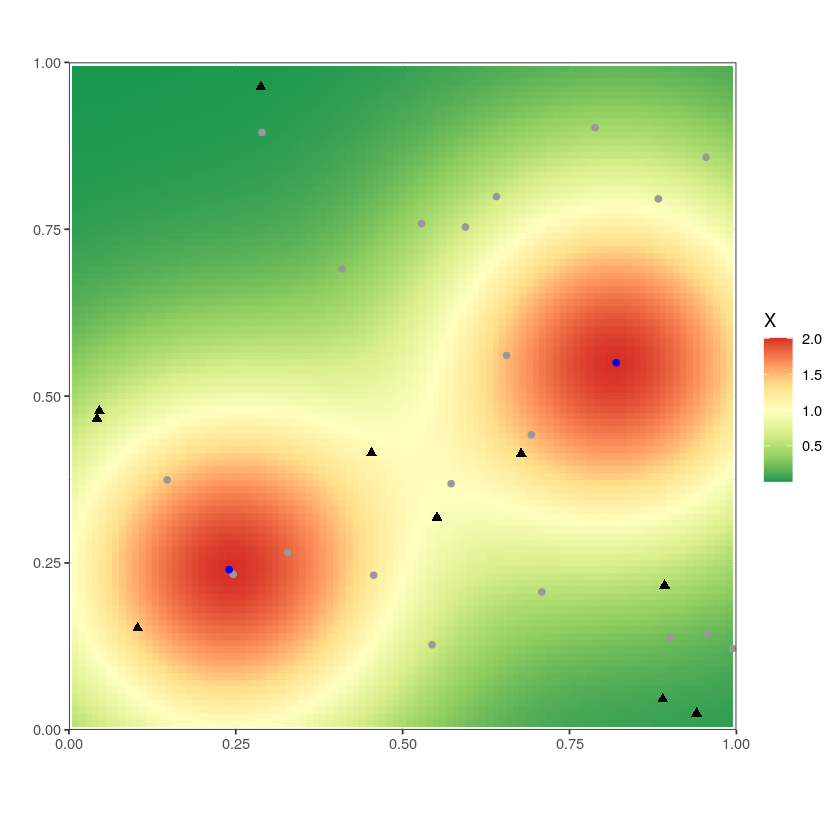

In [12]:
# plot risk factor
ggplot() + 
geom_tile(data = X.coord, aes(x = x, y = y, fill = Xvalue)) + 
coord_equal() +
theme_bw() +
scale_fill_distiller(palette = "RdYlGn") +
geom_point(data = coord[coord$sampled == 0,], aes(x, y), col = "gray60") +
geom_point(data = coord[coord$sampled == 1,], aes(x, y), shape = 17, size = 2) +
scale_color_manual(values = c("grey","black")) +
labs(color = "", fill = "X") +
guides(color = FALSE) +
xlab("") +
ylab("") +
geom_point(data = center1, aes(x = x, y = y), col = "blue") +
geom_point(data = center2, aes(x = x, y = y), col = "blue") +
scale_x_continuous(limits = c(0,1), expand = c(0,0)) +
scale_y_continuous(limits = c(0,1), expand = c(0,0))


In [13]:
#============= extract X for sampled and alternative sites ==========
X.raster.raster <- rasterFromXYZ(X.coord)
coord.sampled$Xvalue <- raster::extract(X.raster.raster$Xvalue, coord.sampled[,1:2])
coord.unsampled$Xvalue <- raster::extract(X.raster.raster$Xvalue, coord.unsampled[,1:2])

In [14]:
#========= generate log(Y) when rho = 0.1 or 0.3 ================
sampled.dist <- as.matrix(dist(coord.sampled[,c("x","y")]))

In [15]:
for(i in 1:length(Y.range))
{
  set.seed(123)
  current.cov.sampled <- s.cov(sampled.dist, Y.sigmas, Y.range[i], Y.sigmad)
  ##coord.sampled[paste("logYValue",Y.range[i], sep = "")] <- beta0 + beta1*coord.sampled$Xvalue + rmvn(n = 1, mu = rep(0, n.initial), sigma = current.cov.sampled, ncores = 7)[1,]
  coord.sampled[paste("logYValue",Y.range[i], sep = "")] <- beta0 + beta1*coord.sampled$Xvalue + rmvn(n = 1, mu = rep(0, n.initial), sigma = current.cov.sampled, ncores = NumThread )[1,]
}


In [16]:
#========================= Figure 2 ==============================
Figure2A <- ggplot() + 
  geom_tile(data = X.coord, aes(x = x, y = y, fill = Xvalue)) + 
  scale_fill_distiller(palette = "Blues", direction = 1) +   # background color
  geom_point(data = coord[coord$sampled == 0,], aes(x, y), col = "gray50", shape = 1) +  # alternative sites
  geom_point(data = coord.sampled, aes(x, y),shape = 2, size = 3) +   # initial design
  geom_point(data = center1, aes(x = x, y = y), shape = 3, size = 2, col = "white") +   # point source 1
  geom_point(data = center2, aes(x = x, y = y), shape = 3, size = 2, col = "white") +   # point source 2
  labs(fill = "Risk factor", x = "", y = "") + 
  ggtitle("(A) Risk factor X") +
  coord_equal() + 
  theme_bw() + 
  theme(legend.position = "bottom", legend.key.size = unit(0.4, "cm")) + 
  scale_x_continuous(limits = c(0,1), expand = c(0,0)) + 
  scale_y_continuous(limits = c(0,1), expand = c(0,0))

In [17]:
# kriging interpolation
coord.sampled.sp <- coord.sampled
coordinates(coord.sampled.sp) = ~ x+y

In [18]:
coord.grid <- X.coord
gridded(coord.grid) = ~x+y

In [19]:
krige0.1 <- krige(logYValue0.1 ~ Xvalue, coord.sampled.sp, coord.grid, model = vgm(psill = Y.sigmas^2, model = "Exp", range = Y.range[1], nugget = Y.sigmad^2), nsim = 1, nmax = 60, beta = c(beta0, beta1))
krige0.3 <- krige(logYValue0.3 ~ Xvalue, coord.sampled.sp, coord.grid, model = vgm(psill = Y.sigmas^2, model = "Exp", range = Y.range[2], nugget = Y.sigmad^2), nsim = 1, nmax = 60, beta = c(beta0, beta1))

[using conditional Gaussian simulation]
[using conditional Gaussian simulation]


In [20]:

X.coord$Y0.1 <- krige0.1$sim1
X.coord$Y0.3 <- krige0.3$sim1

In [21]:
Figure2B <- ggplot() + 
  geom_tile(data = X.coord, aes(x = x, y = y, fill = Y0.1)) +   # background color
  geom_point(data = coord[coord$sampled == 0,], aes(x, y), col = "gray50", shape = 1) +  # alternative sites
  geom_point(data = coord.sampled, aes(x, y, fill = logYValue0.1),size = 3, shape = 2) + # initial design
  geom_point(data = center1, aes(x = x, y = y), shape = 3, size = 2, col = "black") +  # point source 1
  geom_point(data = center2, aes(x = x, y = y), shape = 3, size = 2, col = "black")  +  # point source 2
  geom_contour(data = X.coord, aes(x, y, z = Xvalue), col = "gray") +  # X
  scale_fill_distiller(palette = "RdYlGn", limits = c(min(c(coord.sampled$YValue0.1, coord.sampled$YValue0.3, X.coord$Y0.1, X.coord$Y0.3))-0.1, max(c(coord.sampled$YValue0.1, coord.sampled$YValue0.3, X.coord$Y0.1, X.coord$Y0.3))+0.1)) +
  labs(x = "", y = "", fill = "Log prevalence rate", title = expression("(B) Log prevalence rate when "~rho~" = 0.1")) + 
  coord_equal() + 
  theme_bw() + 
  theme(legend.position = "bottom", legend.key.size = unit(0.4, "cm")) + 
  scale_x_continuous(limits = c(0,1), expand = c(0,0)) + 
  scale_y_continuous(limits = c(0,1), expand = c(0,0))

In [22]:
Figure2C <- ggplot() + 
  geom_tile(data = X.coord, aes(x = x, y = y, fill = Y0.3)) + 
  geom_point(data = coord[coord$sampled == 0,], aes(x, y), col = "gray50", shape = 1) + 
  geom_point(data = coord.sampled, aes(x, y),shape = 2, size = 3) + 
  geom_point(data = center1, aes(x = x, y = y), shape = 3, size = 2, col = "black") + 
  geom_point(data = center2, aes(x = x, y = y), shape = 3, size = 2, col = "black") + 
  geom_contour(data = X.coord, aes(x, y, z = Xvalue), col = "gray") + 
  scale_fill_distiller(palette = "RdYlGn", limits = c(min(c(coord.sampled$YValue0.1, coord.sampled$YValue0.3, X.coord$Y0.1, X.coord$Y0.3))-0.1, max(c(coord.sampled$YValue0.1, coord.sampled$YValue0.3, X.coord$Y0.1, X.coord$Y0.3))+0.1)) +
  labs(x = "", y = "", fill = "Log prevalence rate", title = expression("(C) Log prevalence rate when "~rho~" = 0.3")) + 
  coord_equal() + 
  theme_bw() + 
  theme(legend.position = "bottom", legend.key.size = unit(0.4, "cm")) + 
  scale_x_continuous(limits = c(0,1), expand = c(0,0)) + 
  scale_y_continuous(limits = c(0,1), expand = c(0,0))

null device 
          1

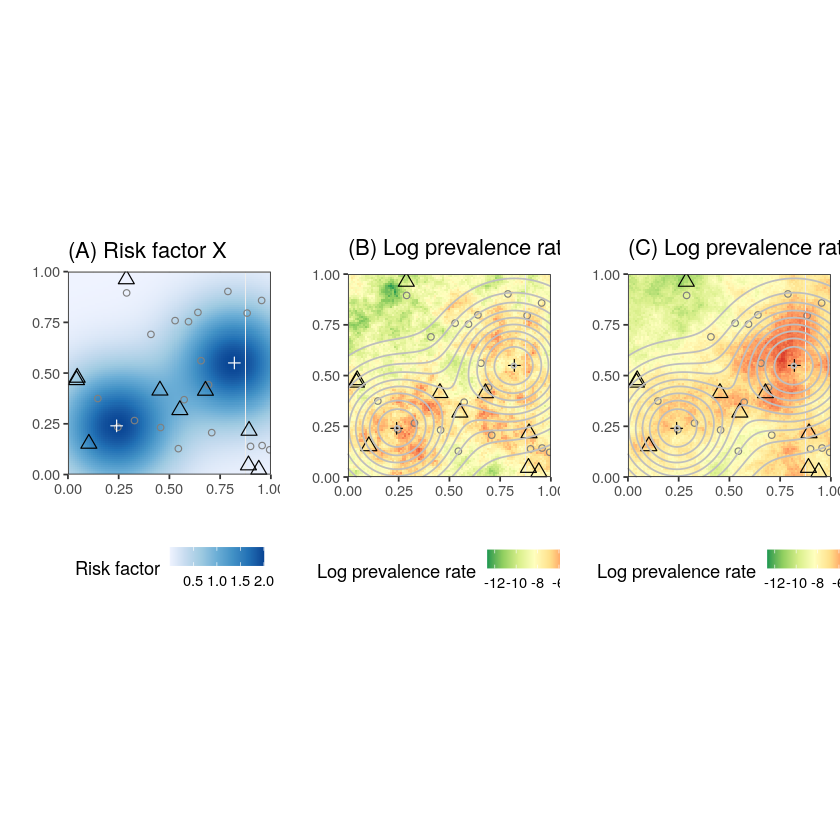

In [23]:
plot_grid(Figure2A, Figure2B, Figure2C, nrow = 1)
dev.off()

In [24]:
#==========================================================
#               Fitting disease model
#==========================================================
# estimate parameters when rho = 0.1
coord.sampled.geodata <- as.geodata(coord.sampled, coords.col = 1:2, data.col = 5, covar.col = 4, covar.names = "Xvalue")


In [25]:
initial.ml.1 <- likfit(coords = coord.sampled[, c("x","y")], 
                       data = coord.sampled$logYValue0.1, 
                       trend = trend.spatial(~Xvalue, coord.sampled.geodata), 
                       ini.cov.pars = c(1, 1), 
                       fix.nugget = FALSE,
                       nugget = 1, 
                       cov.model = "exponential", 
                       lik.method = "ML")
## likfit - Likelihood Based Parameter Estimation For Gaussian Random Fields
## https://www.rdocumentation.org/packages/geoR/versions/1.8-1/topics/likfit


kappa not used for the exponential correlation function
---------------------------------------------------------------
likfit: likelihood maximisation using the function optim.
likfit: Use control() to pass additional
         arguments for the maximisation function.
        For further details see documentation for optim.
likfit: It is highly advisable to run this function several
        times with different initial values for the parameters.
likfit: WARNING: This step can be time demanding!
---------------------------------------------------------------
likfit: end of numerical maximisation.


In [26]:
print(initial.ml.1) ##

likfit: estimated model parameters:
    beta0     beta1     tausq   sigmasq       phi 
"-8.7570" " 1.7093" " 0.0999" " 0.8004" " 0.3023" 
Practical Range with cor=0.05 for asymptotic range: 0.9057253

likfit: maximised log-likelihood = -11.9


In [27]:
# estimate parameters when rho = 0.3
coord.sampled.geodata <- as.geodata(coord.sampled, coords.col = 1:2, data.col = 5, covar.col = 4, covar.names = "Xvalue")


In [28]:
initial.ml.3 <- likfit(coords = coord.sampled[, c("x","y")], 
                       data = coord.sampled$logYValue0.3,     ## here is 0.3 instead of 0.1
                       trend = trend.spatial(~Xvalue, coord.sampled.geodata), 
                       ini.cov.pars = c(1, 0.3),              ## 0.3 instead of 1
                       fix.nugget = FALSE, 
                       nugget = 0.1,                          ## 0.1 instead of 1
                       cov.model = "exponential", 
                       lik.method = "ML")


kappa not used for the exponential correlation function
---------------------------------------------------------------
likfit: likelihood maximisation using the function optim.
likfit: Use control() to pass additional
         arguments for the maximisation function.
        For further details see documentation for optim.
likfit: It is highly advisable to run this function several
        times with different initial values for the parameters.
likfit: WARNING: This step can be time demanding!
---------------------------------------------------------------
likfit: end of numerical maximisation.


In [29]:
print('about to start rho=0.1 n.real realization ####')
system('id -a; hostname; pwd -P; date', intern=TRUE)

[1] "about to start rho=0.1 n.real realization ####"


[1] "uid=0(root) gid=0(root) groups=0(root)"
[2] "3ff288903d14"                          
[3] "/mnt/code"                             
[4] "Sun 27 Sep 2020 12:35:35 PM PDT"

In [30]:
#==========================================================
#    Generate n.real realizations of the disease data
#==========================================================
#============ A. generate n.real sets of the unmeasured 70 sites ==========
# rho = 0.1
coord.sampled.sp <- coord.sampled
coordinates(coord.sampled.sp) = ~ x+y

coord.unsampled.sp <- coord.unsampled
coordinates(coord.unsampled.sp) = ~ x+y

In [145]:
#cat( initial.ml.1$phi, n.real, "\n" ) ##  seems like need phi ~0.3 for model to run
#cat( dim(coord.sampled), dim(coord.unsampled), "\n" ) 
#print( coord.sampled )
#print( coord.unsampled )

In [32]:
krige0.1.sim <- krige(logYValue0.1 ~ Xvalue, coord.sampled.sp, coord.unsampled.sp, 
                      model = vgm(psill = (initial.ml.1$sigmasq)^2, 
                                  model = "Exp", range = initial.ml.1$phi, 
                                  nugget = (initial.ml.1$tausq)^2), 
                      nsim = n.real,   ## have tried as few as 10
                      nmax = 60, 
                      beta = c(initial.ml.1$beta[1],initial.ml.1$beta[2])) 

[using conditional Gaussian simulation]


In [33]:
# rho = 0.3
krige0.3.sim <- krige(logYValue0.3 ~ Xvalue, 
                      coord.sampled.sp, 
                      coord.unsampled.sp, 
                      model = vgm(psill = (initial.ml.3$sigmasq)^2, 
                                  model = "Exp", 
                                  range = initial.ml.3$phi, 
                                  nugget = (initial.ml.3$tausq)^2), 
                      nsim = n.real, 
                      nmax = 60, 
                      beta = c(initial.ml.3$beta[1],initial.ml.3$beta[2])
                     )

[using conditional Gaussian simulation]


In [34]:
#=========== B. generate n.real realizations at the grid for Figure 3=========
# this is not part of DIOS, just for better visualization
# Generate the 41*41 grid 
X.coord <- expand.grid(x = seq(0, 1, 0.025), y = seq(0, 1, 0.025))
X.coord$Xvalue <- dnorm(sqrt((X.coord$x - center1$x)^2 + (X.coord$y - center1$y)^2), mean = 0, sd = sigma) + dnorm(sqrt((X.coord$x - center2$x)^2 + (X.coord$y - center2$y)^2), mean = 0, sd = sigma)

In [35]:
X.coord.sp <- X.coord
coordinates(X.coord.sp) = ~ x + y

In [36]:
# rho = 0.1
krige0.1.sim.grid <- krige(logYValue0.1 ~ Xvalue, coord.sampled.sp, X.coord.sp, model = vgm(psill = (initial.ml.1$sigmasq)^2, model = "Exp", range = initial.ml.1$phi, nugget = (initial.ml.1$tausq)^2), nsim = n.real, nmax = 60, beta = c(initial.ml.1$beta[1],initial.ml.1$beta[2]))

[using conditional Gaussian simulation]


In [37]:
# extract values for the unobserved sites
krige0.1.grid.extract <- list()
for(i in 1:n.real)
{
  current.data <- data.frame(x = X.coord$x, y = X.coord$y, YValue = krige0.1.sim.grid[[i]])
  current.raster <- rasterFromXYZ(current.data)
  krige0.1.grid.extract[[i]] <- raster::extract(current.raster$YValue, coord.unsampled[,1:2])
}

In [38]:
# rho = 0.3
krige0.3.sim.grid <- krige(logYValue0.3 ~ Xvalue, coord.sampled.sp, X.coord.sp, model = vgm(psill = (initial.ml.3$sigmasq)^2, model = "Exp", range = initial.ml.3$phi, nugget = (initial.ml.3$tausq)^2), nsim = n.real, nmax = 60, beta = c(initial.ml.3$beta[1],initial.ml.3$beta[2]))

[using conditional Gaussian simulation]


In [39]:
# extract values for the unobserved sites
krige0.3.grid.extract <- list()
for(i in 1:n.real)
{
  current.data <- data.frame(x = X.coord$x, y = X.coord$y, YValue = krige0.3.sim.grid[[i]])
  current.raster <- rasterFromXYZ(current.data)
  krige0.3.grid.extract[[i]] <- raster::extract(current.raster$YValue, coord.unsampled[,1:2])
}

In [40]:
#==========================================================
#           choose one optimal set
#==========================================================
# Since the design space is small, exhaustive search is done here

In [41]:

#=============== A. Evaluate objective function at alternative sites ========
#======== rho = 0.1 =========
# Took ~15 mins using 7 threads of Intel Core i7-7700 CPU        
## next one now finish in 1-3 min when n.total, n.initial + n.candidate are reduced from 100/30+70 to 34/10+24
##cl <- makeCluster(detectCores()-1, outfile = "log_A_rho0.1.txt") ##
cl <- makeCluster(NumThread, outfile = "log_A_rho0.1.txt") ##
registerDoParallel(cl)

# loop over all realizations
OFV0.1 <- foreach(i = 1:n.real, .combine = "rbind", .packages = c("sp","gstat","geoR")) %dopar%
{
  cat(i, format(Sys.time(),usetz = TRUE), "\n")
  
  # loop over all 70 possible designs
  ## result <- data.frame(dataID = i, siteID = 1:70, OFV1 = NA, OFV2 = NA)
  result <- data.frame(dataID = i, siteID = 1:n.candidate, OFV1 = NA, OFV2 = NA)
  for(j in 1:n.candidate)   ## for(j in 1:70)
  {
    # combine intial design and the "selected" site
    coord.sampled.current.sp <- rbind(coord.sampled[,c("x","y","Xvalue","logYValue0.1")], 
                                      data.frame(x = coord.unsampled[j,"x"], 
                                                 y = coord.unsampled[j,"y"], 
                                                 Xvalue = coord.unsampled[j,"Xvalue"], 
                                                 logYValue0.1 = krige0.1.sim[[i]][j]))
    coord.sampled.geodata <- as.geodata(coord.sampled.current.sp, 
                                        coords.col = 1:2, 
                                        data.col = 4, 
                                        covar.col = 3, 
                                        covar.names = "Xvalue")
    coordinates(coord.sampled.current.sp) <- ~x+y
    
    # remove the "selected" site from the alternative site
    coord.unsampled.current.sp <- coord.unsampled[-j,]
    coordinates(coord.unsampled.current.sp) = ~x+y
    
    # predict the 69 unobserved sites
    krige.current.sim <- krige(logYValue0.1 ~ Xvalue, 
                               coord.sampled.current.sp, 
                               coord.unsampled.current.sp, 
                               model = vgm(psill = (initial.ml.1$sigmasq)^2, 
                                           model = "Exp", 
                                           range = initial.ml.1$phi, 
                                           nugget = (initial.ml.1$tausq)^2), 
                               beta = c(initial.ml.1$beta[1],initial.ml.1$beta[2]), 
                               debug.level = 0)
    
    # calculate MSE of the spatial prediction - objective 1
    result$OFV1[j] <- mean((krige.current.sim$var1.pred - krige0.1.sim[[i]][-j])^2)
    
    # calculate var(beta1) - Objective function 2
    current.ml <- likfit(coords = coordinates(coord.sampled.current.sp), 
                         data = coord.sampled.current.sp$logYValue0.1, 
                         trend = trend.spatial(~Xvalue, coord.sampled.geodata), 
                         ini.cov.pars = c(1, 0.3), 
                         fix.nugget = FALSE, 
                         nugget = 0.1, 
                         cov.model = "exponential", 
                         lik.method = "ML", 
                         messages = FALSE)
    
    result$OFV2[j] <- current.ml$beta.var[2,2]
  }
  result   # this output content of result, but got redirected to file cuz cluster object 
}
stopCluster(cl)

In [42]:
## above takes a few minutes to complete

In [43]:
print('about to start rho=0.3 ####')
system('id -a; hostname; pwd -P; date', intern=TRUE)

[1] "about to start rho=0.3 ####"


[1] "uid=0(root) gid=0(root) groups=0(root)"
[2] "3ff288903d14"                          
[3] "/mnt/code"                             
[4] "Sun 27 Sep 2020 12:35:48 PM PDT"

In [44]:
## Can A vs B and rho=0.1 and rho=0.3 be run in parallel ??
## can foreach %dopar% be nested ??

In [45]:
#======== rho = 0.3 =============
# Took ~15 mins using 7 threads of Intel Core i7-7700 CPU
#cl <- makeCluster(detectCores()-1, outfile = "log.txt")
cl <- makeCluster(NumThread, outfile = "log_A_rho0.3.txt") ##
registerDoParallel(cl)
OFV0.3 <- foreach(i = 1:n.real, .combine = "rbind", .packages = c("sp","gstat","geoR")) %dopar%
{
  cat(i, format(Sys.time(),usetz = TRUE), "\n")
  
  ##result <- data.frame(dataID = i, siteID = 1:70, OFV1 = NA, OFV2 = NA)
  ##for(j in 1:70)

    
  result <- data.frame(dataID = i, siteID = 1:n.candidate, OFV1 = NA, OFV2 = NA)
  for(j in 1:n.candidate)
  {
    # MSE
    coord.sampled.current.sp <- rbind(coord.sampled[,c("x","y","Xvalue","logYValue0.3")], 
                                      data.frame(x = coord.unsampled[j,"x"], 
                                                 y = coord.unsampled[j,"y"], 
                                                 Xvalue = coord.unsampled[j,"Xvalue"], 
                                                 logYValue0.3 = krige0.3.sim[[i]][j]))     ## change from krige0.1.sim...
    coord.sampled.geodata <- as.geodata(coord.sampled.current.sp, coords.col = 1:2, data.col = 4, covar.col = 3, covar.names = "Xvalue")
    coordinates(coord.sampled.current.sp) <- ~x+y
    
    coord.unsampled.current.sp <- coord.unsampled[-j,]
    coordinates(coord.unsampled.current.sp) = ~x+y
    
                               ## vvvvv instead of logYValue0.1
    krige.current.sim <- krige(logYValue0.3 ~ Xvalue, coord.sampled.current.sp, coord.unsampled.current.sp,
                               model = vgm(psill = (initial.ml.3$sigmasq)^2, 
                                           model = "Exp", 
                                           range = initial.ml.3$phi, 
                                           nugget = (initial.ml.3$tausq)^2), 
                               beta = c(initial.ml.3$beta[1],initial.ml.3$beta[2]), 
                               debug.level = 0)
                                                          ## VVVVVV instead of krige0.1.sim
    result$OFV1[j] <- mean((krige.current.sim$var1.pred - krige0.3.sim[[i]][-j])^2)
    # result$OFV1[j] <- mean((krige.current.sim$sim1 - krige0.3.mean[-j])^2)
    
    # var beta1
    current.ml <- likfit(coords = coordinates(coord.sampled.current.sp), data = coord.sampled.current.sp$logYValue0.3, trend = trend.spatial(~Xvalue, coord.sampled.geodata), ini.cov.pars = c(1, 0.3), fix.nugget = FALSE, nugget = 0.1, cov.model = "exponential", lik.method = "ML", messages = FALSE)
    
    result$OFV2[j] <- current.ml$beta.var[2,2]
  }
  
  result
}
stopCluster(cl)

In [46]:
##result
## pause...  

In [47]:
print('about to start B eval obj fn with rho=0.1 ######')
system('id -a; hostname; pwd -P; date', intern=TRUE)

[1] "about to start B eval obj fn with rho=0.1 ######"


[1] "uid=0(root) gid=0(root) groups=0(root)"
[2] "3ff288903d14"                          
[3] "/mnt/code"                             
[4] "Sun 27 Sep 2020 12:36:21 PM PDT"

In [48]:
##
## *** next one takes a long time !!! ***
##
## line 334 of DIOS_demonstration.R 
## this one still take ~2-3min with  n.total, n.initial, n.candidate to 34/10+24 
## (docker on bofh) start 11:53... load 3.1... end 11:57

In [49]:
#========= B. evaluate objective function at 41*41 grids as in Figure 3 ========
#======== rho = 0.1 =============
# Took ~9.5 hrs mins using 7 threads of Intel Core i7-7700 CPU
#cl <- makeCluster(detectCores()-1, outfile = "log.txt")
cl <- makeCluster(NumThread, outfile = "log_B_rho0.1.txt") ##
registerDoParallel(cl)
OFV0.1.grid <- foreach(i = 1:n.real, .combine = "rbind", .packages = c("sp","gstat","geoR")) %dopar%   # loop over all realizations
{
  cat(i, format(Sys.time(),usetz = TRUE), "\n")
  
  result <- data.frame(dataID = i, siteID = 1:nrow(X.coord), OFV1 = NA, OFV2 = NA)
  for(j in 1:nrow(X.coord))   # loop over all pixels
  {
    # MSE
    coord.sampled.current.sp <- rbind(coord.sampled[,c("x","y","Xvalue","logYValue0.1")], data.frame(x = X.coord[j,"x"], y = X.coord[j,"y"], Xvalue = X.coord[j,"Xvalue"], logYValue0.1 = krige0.1.sim.grid[[i]][j]))
    coord.sampled.geodata <- as.geodata(coord.sampled.current.sp, coords.col = 1:2, data.col = 4, covar.col = 3, covar.names = "Xvalue")
    coordinates(coord.sampled.current.sp) <- ~x+y
    
    coord.unsampled.current.sp <- coord.unsampled
    coordinates(coord.unsampled.current.sp) = ~x+y
    
    krige.current.sim <- krige(logYValue0.1 ~ Xvalue, coord.sampled.current.sp, coord.unsampled.current.sp, model = vgm(psill = (initial.ml.1$sigmasq)^2 , model = "Exp", range = initial.ml.1$phi, nugget = (initial.ml.1$tausq)^2), beta = c(initial.ml.1$beta[1],initial.ml.1$beta[2]), debug.level = 0)
    
    result$OFV1[j] <- mean((krige.current.sim$var1.pred - krige0.1.grid.extract[[i]])^2)
    
    # var beta1
    current.ml <- likfit(coords = coordinates(coord.sampled.current.sp), data = coord.sampled.current.sp$logYValue0.1, trend = trend.spatial(~Xvalue, coord.sampled.geodata), ini.cov.pars = c(1, 0.3), fix.nugget = FALSE, nugget = 0.1, cov.model = "exponential", lik.method = "ML", messages = FALSE)
    
    result$OFV2[j] <- current.ml$beta.var[2,2]
  }
  
  result
}
stopCluster(cl)

In [50]:
## line 370 of DIOS_demonstration.R 
## log portion takes ~1min?        (sites as 34/10/24)
## the whole thing takes ~8 min?

In [51]:
#======== rho = 0.3 =============
# Took ~9.5 hrs using 7 threads of Intel Core i7-7700 CPU
##cl <- makeCluster(detectCores()-1, outfile = "log.txt")
cl <- makeCluster(NumThread, outfile = "log_B_rho0.3.txt") ##
registerDoParallel(cl)
OFV0.3.grid <- foreach(i = 1:n.real, .combine = "rbind", .packages = c("sp","gstat","geoR")) %dopar%   # loop over all realizations
{
  cat(i, format(Sys.time(),usetz = TRUE), "\n")
  
  result <- data.frame(dataID = i, siteID = 1:nrow(X.coord), OFV1 = NA, OFV2 = NA)
  for(j in 1:nrow(X.coord))   # loop over all pixels
  {
    # MSE
    coord.sampled.current.sp <- rbind(coord.sampled[,c("x","y","Xvalue","logYValue0.3")], data.frame(x = X.coord[j,"x"], y = X.coord[j,"y"], Xvalue = X.coord[j,"Xvalue"], logYValue0.3 = krige0.3.sim.grid[[i]][j]))
    coord.sampled.geodata <- as.geodata(coord.sampled.current.sp, coords.col = 1:2, data.col = 4, covar.col = 3, covar.names = "Xvalue")
    coordinates(coord.sampled.current.sp) <- ~x+y
    
    coord.unsampled.current.sp <- coord.unsampled
    coordinates(coord.unsampled.current.sp) = ~x+y
    
    krige.current.sim <- krige(logYValue0.3 ~ Xvalue, coord.sampled.current.sp, coord.unsampled.current.sp, model = vgm(psill = (initial.ml.3$sigmasq)^2, model = "Exp", range = initial.ml.3$phi, nugget = (initial.ml.3$tausq)^2), beta = c(initial.ml.3$beta[1],initial.ml.3$beta[2]), debug.level = 0)
    
    result$OFV1[j] <- mean((krige.current.sim$var1.pred - krige0.3.grid.extract[[i]])^2)
    
    # var beta1
    current.ml <- likfit(coords = coordinates(coord.sampled.current.sp), data = coord.sampled.current.sp$logYValue0.3, trend = trend.spatial(~Xvalue, coord.sampled.geodata), ini.cov.pars = c(1, 0.3), fix.nugget = FALSE, nugget = 0.1, cov.model = "exponential", lik.method = "ML", messages = FALSE)
    
    result$OFV2[j] <- current.ml$beta.var[2,2]
  }
  
  result
}
stopCluster(cl)


In [52]:
#=========== plot results for selecting one additional site for each objective ====
#===========Figure 3 ===========
# coord.sampled <- read.csv("coord.sampled.csv")
# coord.unsampled <- read.csv("coord.unsampled.csv")
# 
# OFV0.1.grid <- read.csv("OFV 0.1 grid.csv")
# OFV0.3.grid <- read.csv("OFV 0.3 grid.csv")

OFV01.agg <- OFV0.1.grid %>% group_by(siteID) %>% summarise(OFV1 = mean(OFV1), OFV2 = mean(OFV2))
OFV03.agg <- OFV0.3.grid %>% group_by(siteID) %>% summarise(OFV1 = mean(OFV1), OFV2 = mean(OFV2))

OFV01.agg$x <- X.coord$x
OFV01.agg$y <- X.coord$y

OFV03.agg$x <- X.coord$x
OFV03.agg$y <- X.coord$y

OFV1.01.raster <- rasterFromXYZ(OFV01.agg[,c("x","y","OFV1","OFV2")])
coord.unsampled$OFV1.01 <- raster::extract(OFV1.01.raster$OFV1, coord.unsampled[,c("x","y")])
coord.unsampled$OFV2.01 <- raster::extract(OFV1.01.raster$OFV2, coord.unsampled[,c("x","y")])

OFV3.01.raster <- rasterFromXYZ(OFV03.agg[,c("x","y","OFV1","OFV2")])
coord.unsampled$OFV1.03 <- raster::extract(OFV3.01.raster$OFV1, coord.unsampled[,c("x","y")])
coord.unsampled$OFV2.03 <- raster::extract(OFV3.01.raster$OFV2, coord.unsampled[,c("x","y")])

In [53]:
Figure3A <- ggplot() + 
  geom_tile(data = OFV01.agg, aes(x = x, y = y, fill =  OFV1)) +  # OFV
  geom_point(data = center1, aes(x = x, y = y), shape = 3, size = 2, col = "white", stroke = 2) + # point source 1
  geom_point(data = center2, aes(x = x, y = y), shape = 3, size = 2, col = "white", stroke = 2) + # point source 2
  geom_point(data = coord.sampled, aes(x, y), shape = 2, size = 2) +  # initial design
  geom_point(data = coord.unsampled[-which.min(coord.unsampled$OFV1.01),], aes(x, y), col = "gray40", shape = 1, size = 2) +  # unselected alternative sites
  geom_point(data = coord.unsampled[which.min(coord.unsampled$OFV1.01),], aes(x = x, y = y), col = "cyan", shape = 1, stroke = 2, size = 2) +   # optimal site to add
  scale_fill_distiller(palette = "OrRd", direction = -1) + 
  scale_color_manual(values = c("grey","black")) + 
  scale_x_continuous(limits = c(0,1), expand = c(0,0)) + 
  scale_y_continuous(limits = c(0,1), expand = c(0,0))+
  labs(fill = "OFV 1", x = "", y = "") + 
  ggtitle("(A) Spatial interpolation, ρ = 0.1") +
  coord_equal() + 
  theme_bw()+ 
  theme(legend.position="bottom", legend.key.width = unit(1.2,"cm"), legend.key.height = unit(0.4,"cm"),legend.margin=margin(-20,0,0,0)) + 
  guides(color = FALSE, fill = guide_colourbar(label.theme = element_text(angle = 30, hjust = 1, size = 8), reverse = FALSE))


In [54]:
Figure3B <- ggplot() + 
  geom_tile(data = OFV03.agg, aes(x = x, y = y, fill =  OFV1)) + 
  geom_point(data = center1, aes(x = x, y = y), shape = 3, size = 2, col = "white", stroke = 2) + 
  geom_point(data = center2, aes(x = x, y = y), shape = 3, size = 2, col = "white", stroke = 2) + 
  geom_point(data = coord.sampled, aes(x, y), shape = 2, size = 2) + 
  geom_point(data = coord.unsampled[-which.min(coord.unsampled$OFV1.03),], aes(x, y), col = "gray40", shape = 1, size = 2) + 
  geom_point(data = coord.unsampled[which.min(coord.unsampled$OFV1.03),], aes(x = x, y = y), size = 2, col = "cyan", shape = 1, stroke = 2) + 
  scale_fill_distiller(palette = "OrRd", direction = -1) +
  scale_color_manual(values = c("grey","black")) + 
  scale_x_continuous(limits = c(0,1), expand = c(0,0)) + 
  scale_y_continuous(limits = c(0,1), expand = c(0,0))+ 
  labs(fill = "OFV 1", x = "", y = "") + 
  ggtitle("(B) Spatial interpolation, ρ = 0.3") + 
  coord_equal() + 
  theme_bw()+ 
  theme(legend.position="bottom", legend.key.width = unit(1.2,"cm"), legend.key.height = unit(0.4,"cm"),legend.margin=margin(-20,0,0,0)) + 
  guides(color = FALSE, fill = guide_colourbar(label.theme = element_text(angle = 30, hjust = 1, size = 8), reverse = FALSE))


In [55]:
Figure3C <- ggplot() + 
  geom_tile(data = OFV01.agg, aes(x = x, y = y, fill =  OFV2)) + 
  geom_point(data = center1, aes(x = x, y = y), shape = 3, size = 2, col = "white", stroke = 2) + 
  geom_point(data = center2, aes(x = x, y = y), shape = 3, size = 2, col = "white", stroke = 2) + 
  geom_point(data = coord.sampled, aes(x, y), shape = 2, size = 2) + 
  geom_point(data = coord.unsampled[-which.min(coord.unsampled$OFV2.01),], aes(x, y), size = 2, col = "gray40", shape = 1) + 
  geom_point(data = coord.unsampled[which.min(coord.unsampled$OFV2.01),], aes(x = x, y = y), size = 2, col = "cyan", shape = 1, stroke = 2) + 
  scale_fill_distiller(palette = "OrRd", direction = -1) + 
  scale_color_manual(values = c("grey","black")) + 
  scale_x_continuous(limits = c(0,1), expand = c(0,0)) + 
  scale_y_continuous(limits = c(0,1), expand = c(0,0))+ 
  labs(fill = "OFV 2", x = "", y = "") + 
  ggtitle("(C) Effect estimation, ρ = 0.1") + 
  coord_equal() + 
  theme_bw()+ 
  theme(legend.position="bottom", legend.key.width = unit(1.2,"cm"), legend.key.height = unit(0.4,"cm"), legend.margin=margin(-20,0,0,0)) + 
  guides(color = FALSE, size = guide_legend(nrow = 2, byrow = TRUE), fill = guide_colourbar(label.theme = element_text(angle = 30, hjust = 1, size = 8), reverse = FALSE))

In [56]:
Figure3D <- ggplot() + 
  geom_tile(data = OFV03.agg, aes(x = x, y = y, fill =  OFV2)) + 
  geom_point(data = center1, aes(x = x, y = y), shape = 3, size = 2, col = "white", stroke = 2) + 
  geom_point(data = center2, aes(x = x, y = y), shape = 3, size = 2, col = "white", stroke = 2) + 
  geom_point(data = coord.sampled, aes(x, y), shape = 2, size = 2) + 
  geom_point(data = coord.unsampled[-which.min(coord.unsampled$OFV2.03),], aes(x, y), size = 2, col = "gray40", shape = 1) + 
  geom_point(data = coord.unsampled[which.min(coord.unsampled$OFV2.03),], aes(x = x, y = y), size = 2, col = "cyan", shape = 1, stroke = 2) + 
  scale_fill_distiller(palette = "OrRd", direction = -1) + 
  scale_color_manual(values = c("grey","black")) + 
  scale_x_continuous(limits = c(0,1), expand = c(0,0)) + 
  scale_y_continuous(limits = c(0,1), expand = c(0,0))+ 
  labs(fill = "OFV 2", x = "", y = "") + 
  ggtitle("(D) Effect estimation, ρ = 0.3") +
  coord_equal() + 
  theme_bw()+ 
  theme(legend.position="bottom", legend.key.width = unit(1.2,"cm"), legend.key.height = unit(0.4,"cm"), legend.margin=margin(-20,0,0,0)) + 
  guides(size = guide_legend(nrow = 2, byrow = TRUE), fill = guide_colourbar(label.theme = element_text(angle = 30, hjust = 1, size = 8), reverse = FALSE))

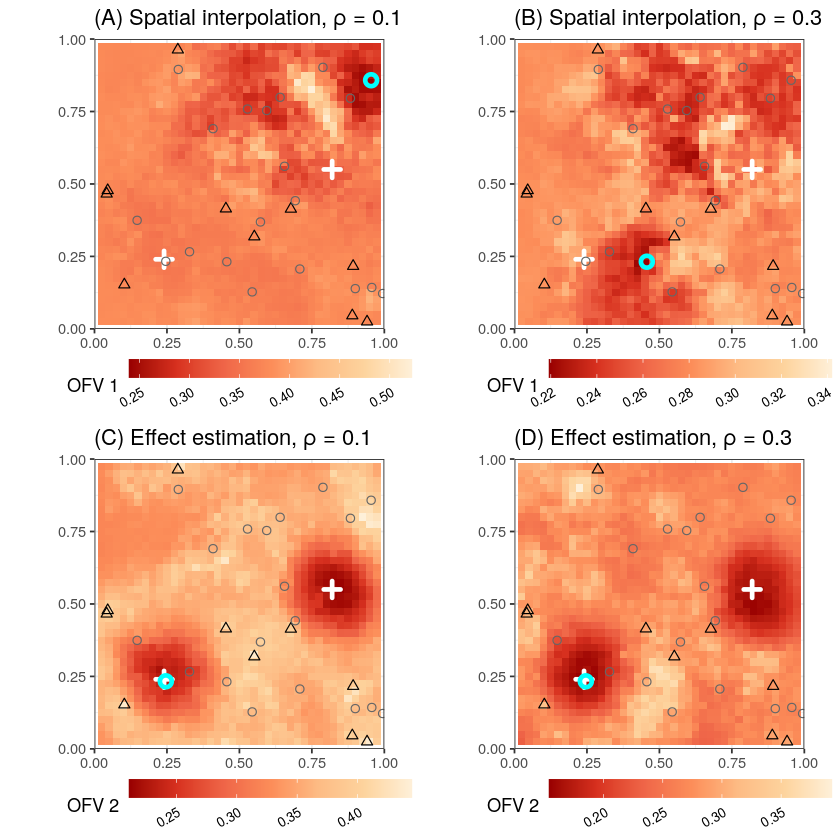

In [57]:
plot_grid(Figure3A, Figure3B, Figure3C, Figure3D)


In [58]:
#====== plot results for selecting one additional site for multiple objectives ====
#======= Figure 4 =======
# OFV0.3 <- read.csv("OFV 0.3.csv")
site.agg <- OFV0.3 %>% group_by(siteID) %>% summarize(OFV1 = mean(OFV1), OFV2 = mean(OFV2))

# OFV0.1 <- read.csv("OFV 0.1.csv")
# site.agg <- OFV0.1 %>% group_by(siteID) %>% summarize(OFV1 = mean(OFV1), OFV2 = mean(OFV2))

In [59]:

site.agg$x <- coord.unsampled$x
site.agg$y <- coord.unsampled$y

sky1 <- psel(site.agg, low(site.agg$OFV1)*low(site.agg$OFV2))
point.col <- brewer.pal(n = nrow(sky1), name = "Set1")

In [60]:
m.obj.p1 <- ggplot(site.agg, aes(x = OFV1, y = OFV2)) + 
  geom_point(shape = 21) + 
  geom_point(data = sky1, size = 3, aes(col = as.factor(siteID))) + 
  theme_bw() + 
  xlab("OFV 1 (spatial interpolation)") + 
  ylab("OFV 2 (effect estimation)") + 
  ggtitle("(A) Pareto set") + 
  scale_color_manual(values = point.col) + 
  guides(col = FALSE)

X.coord <- expand.grid(x = seq(0, 1, 0.01), y = seq(0, 1, 0.01)) # gernerate grid


In [61]:
# generate risk factor level
X.coord$Xvalue <- dnorm(sqrt((X.coord$x - center1$x)^2 + (X.coord$y - center1$y)^2), mean = 0, sd = sigma) + dnorm(sqrt((X.coord$x - center2$x)^2 + (X.coord$y - center2$y)^2), mean = 0, sd = sigma)

coord.grid <- X.coord
gridded(coord.grid) = ~x+y

In [62]:
krige0.1 <- krige(logYValue0.1 ~ Xvalue, coord.sampled.sp, coord.grid, model = vgm(psill = Y.sigmas^2, model = "Exp", range = Y.range[1], nugget = Y.sigmad^2), nsim = 1, nmax = 60, beta = c(beta0, beta1))
krige0.3 <- krige(logYValue0.3 ~ Xvalue, coord.sampled.sp, coord.grid, model = vgm(psill = Y.sigmas^2, model = "Exp", range = Y.range[2], nugget = Y.sigmad^2), nsim = 1, nmax = 60, beta = c(beta0, beta1))

X.coord$Y0.1 <- krige0.1$sim1
X.coord$Y0.3 <- krige0.3$sim1

[using conditional Gaussian simulation]
[using conditional Gaussian simulation]


In [63]:
m.obj.p2 <- ggplot() + 
  geom_tile(data = X.coord, aes(x = x, y = y, fill = Y0.3)) + 
  scale_fill_distiller(palette = "RdYlGn", limits = c(min(c(coord.sampled$YValue0.1, coord.sampled$YValue0.3, X.coord$Y0.1, X.coord$Y0.3))-0.1, max(c(coord.sampled$YValue0.1, coord.sampled$YValue0.3, X.coord$Y0.1, X.coord$Y0.3))+0.1)) + 
  coord_equal() + 
  theme_bw() + 
  geom_contour(data = X.coord, aes(x, y, z = Xvalue), col = "gray") + 
  geom_point(data = site.agg, aes(x, y), col = "gray60") + 
  geom_point(data = coord.sampled, aes(x, y), shape = 17, size = 2) + 
  labs(color = "", fill = "log(prev)") + guides(color = FALSE, fill = FALSE) + 
  xlab("") + 
  ylab("") + 
  geom_point(data = sky1, aes(x = x, y = y, col = as.factor(siteID)), size = 4, shape = 17) + 
  scale_x_continuous(limits = c(0,1), expand = c(0,0)) + 
  scale_y_continuous(limits = c(0,1), expand = c(0,0)) + 
  ggtitle("(B) Locations of the Pareto set") + scale_color_manual(values = point.col) + 
  guides(col = FALSE)

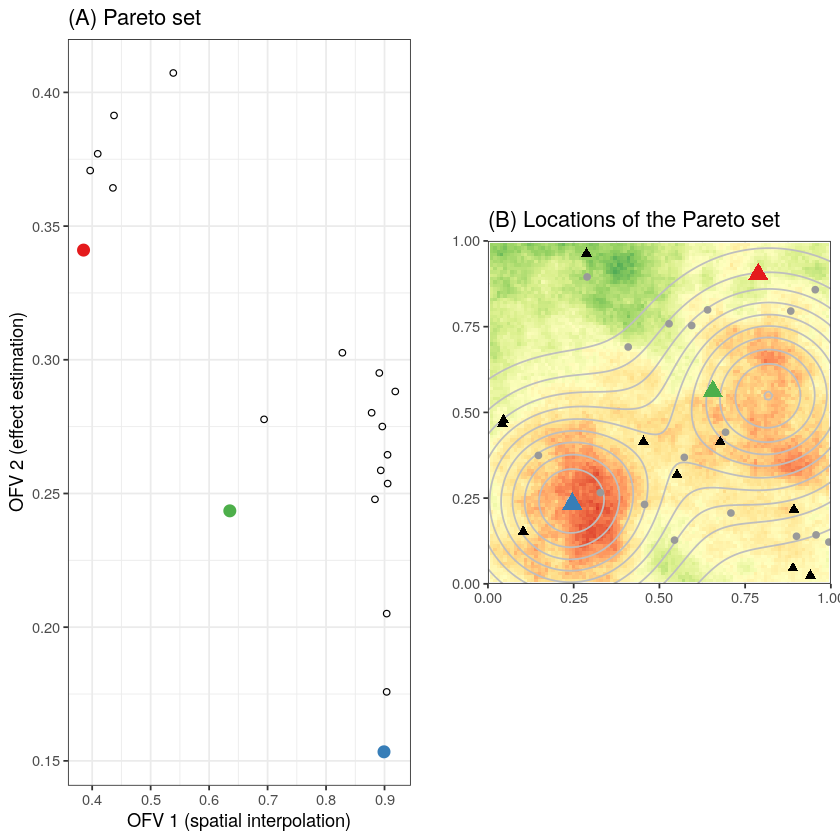

In [64]:
plot_grid(m.obj.p1, m.obj.p2)


In [149]:
## Simulated Annealing next, which still about 3*15 = 45 min !!
## but cpu isn't all that busy...
## docker on bofh: start 12:04... end ~12:19.  so ~15 min.  load avg <1.  
## so not sure why takes so long!  capturing that long ass output to the notebook?
## tweaked simAnneal to double thread, took ~13 min

## zink            nahalem E5620 @ 2.40            2x4x2   32 GB   docker (traditional)
## bof             haswell-EP E5-1660 v3 @ 3.0     1x8x2   64 GB   docker (traditional)
## bgo             skylake Silv 4110 @ 2.1         2x8x2   64 GB   docker (traditional)
## hma             Skylake Silv 4110 @ 2.1         2x8x2   32 GB   sudo podman

## bof     20min per chain. Total 52m    --  30/10//3 n.total/n.initial//n.real [15 thread]
## bgo    ~20min per chain. Total 65m    --  30/10//3 n.total/n.initial//n.real [31 thread]
## hma    ~21min per chain. Total 71m    --  30/10//3 n.total/n.initial//n.real [12 thread for SimAnneal, matching num of memory channel.  Ram use 3-8 GB]
## hma    ~23min per chain. Total 73m    --  30/10//3 n.total/n.initial//n.real [15,16,17 thread for SimAnneal]
## hma    ~25min per chain. Total 82m    --  30/10//3 n.total/n.initial//n.real [31 thread]
## hma    ~30min per chain. Total 100m   --  30/10//3 n.total/n.initial//n.real [63 thread]

## n170   ~11min per chain. Total 38m    --  30/10//3 n.total/n.initial//n.real [39 thread]


## titan  

print("\n\n")
print("## **==** ----------------------------------------------------------- ")
print("## **==** ----------------------------------------------------------- ")

print('about to simulatead annealing ###')

system('date; uptime; hostname', intern=TRUE)
print(system('cat /proc/loadavg', intern=TRUE))

[1] "\n\n"
[1] "## **==** ----------------------------------------------------------- "
[1] "## **==** ----------------------------------------------------------- "
[1] "about to simulatead annealing ###"


[1] "Sun 27 Sep 2020 03:01:39 PM PDT"                                       
[2] " 15:01:39 up 68 days, 22:24,  0 users,  load average: 0.06, 0.08, 0.50"
[3] "3ff288903d14"

[1] "0.06 0.08 0.50 2/1923 4764"


In [150]:
##cat( "## existing.sites", dim(coord.sampled), "\n" ) 
##print( coord.sampled )
##// cat( "## alt.sites", dim(coord.unsampled), "\n" ) 
#// print( coord.unsampled )

In [102]:
#==========================================================
#       Optimization with simulated annealing
#==========================================================
# ================ SA ===============
# estimate initial temperature according to https://www.barnesandnoble.com/p/iterative-computer-algorithms-with-applications-in-engineering-sadiq-m-sait/1101198004/2660895534523?st=PLA&sid=BNB_ADL+Marketplace+Good+Used+Textbooks+-+Desktop+Low&sourceId=PLAGoNA&dpid=tdtve346c&2sid=Google_c&gclid=EAIaIQobChMIzrzJj8P-4wIVCMJkCh1i1ArmEAYYASABEgIObfD_BwE
# ~9.2 hours on two Intel Xeon 12-core Haswell processors (24 cores in total) 


chain1 <- mcparallel ( 
          SimAnneal(existing.sites = coord.sampled, 
                    alt.sites = coord.unsampled, 
                    n.choose = 3, 
                    rho = "logYValue0.3", 
                    disease.d.set = krige0.3.sim@data, 
                    obj.fun = OBJ1, 
                    initial.ml = initial.ml.3, 
                    neigh.fun = neigh.fun, 
                    T0 = 0.075, 
                    alpha = 0.9987, 
                    T.thres = 1e-6) )

In [104]:
chain2 <- mcparallel( SimAnneal(existing.sites = coord.sampled, alt.sites = coord.unsampled, n.choose = 3, rho = "logYValue0.3", disease.d.set = krige0.3.sim@data, obj.fun = OBJ1, initial.ml = initial.ml.3, neigh.fun = neigh.fun, T0 = 0.075, alpha = 0.9987, T.thres = 1e-6) )

In [106]:
chain3 <- mcparallel( SimAnneal(existing.sites = coord.sampled, alt.sites = coord.unsampled, n.choose = 3, rho = "logYValue0.3", disease.d.set = krige0.3.sim@data, obj.fun = OBJ1, initial.ml = initial.ml.3, neigh.fun = neigh.fun, T0 = 0.075, alpha = 0.9987, T.thres = 1e-6) )

In [108]:
SApar <- mccollect( list(chain1, chain2, chain3) )

In [107]:
print("\n")
print('## **==** finished 3 chains of SimAnneal ### mccollect ch1,2,3 ###')
system('date; uptime; hostname', intern=TRUE)
print(system('cat /proc/loadavg', intern=TRUE))

[1] "\n"
[1] "## **==** finished chain3 of SimAnneal ### ch3 ###"


[1] "Sun 27 Sep 2020 02:16:09 PM PDT"                                       
[2] " 14:16:09 up 68 days, 21:39,  0 users,  load average: 2.28, 0.63, 0.31"
[3] "3ff288903d14"

[1] "2.28 0.63 0.31 4/1957 4654"


In [136]:
##SA1 <- rbind(chain1, chain2, chain3)
SA1tmp <- rbind(SApar[[1]], SApar[[2]], SApar[[3]])

In [137]:
## SA1 <- data.frame(SA1)
SA1 <- data.frame(SA1tmp)

In [139]:
#==== plot results for selecting three additional sites for spatial prediction ====
#======= Figure 5 =======
# rho = 0.3, OFV 1
# SA1 <-  read.csv("SA.OFV1.03.csv")
SA1$BestID <- as.character(SA1$BestID)
SA1$criterion.result <- as.character(SA1$criterion.result)

In [140]:
# plot the chain
result.SA <- NULL
for(i in 1:nrow(SA1))
{
  result.SA <- rbind(result.SA, data.frame(iter = rep(i, each = length(as.numeric(unlist(strsplit(SA1[1,3],","))))), step = 1:length(as.numeric(unlist(strsplit(SA1[1,3],",")))), OFV = as.numeric(unlist(strsplit(SA1[i,3],",")))))
}

In [141]:
Figure5A <- ggplot(result.SA, aes(x = step, y = OFV, col = as.factor(iter), group = iter)) + 
  geom_line() + 
  theme_bw() + 
  xlab("Number of iterations") + 
  ylab("OFV1") + 
  guides(col = FALSE) + 
  ggtitle("(A) Examples of SA runs")

In [142]:
BestID <- as.numeric(unlist(strsplit(SA1$BestID[1], ",")))


In [143]:
Figure5B <- ggplot() + 
  geom_tile(data = X.coord, aes(x = x, y = y, fill = Y0.3)) + 
  geom_contour(data = X.coord, aes(x, y, z = Xvalue), col = "gray")+ 
  geom_point(data = coord.unsampled, aes(x, y), col = "gray60") + 
  geom_point(data = coord.sampled, aes(x, y), shape = 17, size = 2) + 
  geom_point(data = coord.unsampled[BestID,], aes(x = x, y = y), size = 4, shape = 17, col = "blue") + 
  scale_fill_distiller(palette = "RdYlGn", limits = c(min(c(coord.sampled$YValue0.1, coord.sampled$YValue0.3, X.coord$Y0.1, X.coord$Y0.3))-0.1, max(c(coord.sampled$YValue0.1, coord.sampled$YValue0.3, X.coord$Y0.1, X.coord$Y0.3))+0.1))  + 
  scale_color_manual(values = c("grey","black")) + labs(color = "", fill = "var.both") + 
  scale_x_continuous(limits = c(0,1), expand = c(0,0)) + 
  scale_y_continuous(limits = c(0,1), expand = c(0,0)) + 
  ggtitle("(B) Locations of 3 optimal sites") +
  guides(color = FALSE, fill = FALSE) + 
  xlab("") + 
  ylab("") +
  coord_equal() + 
  theme_bw()

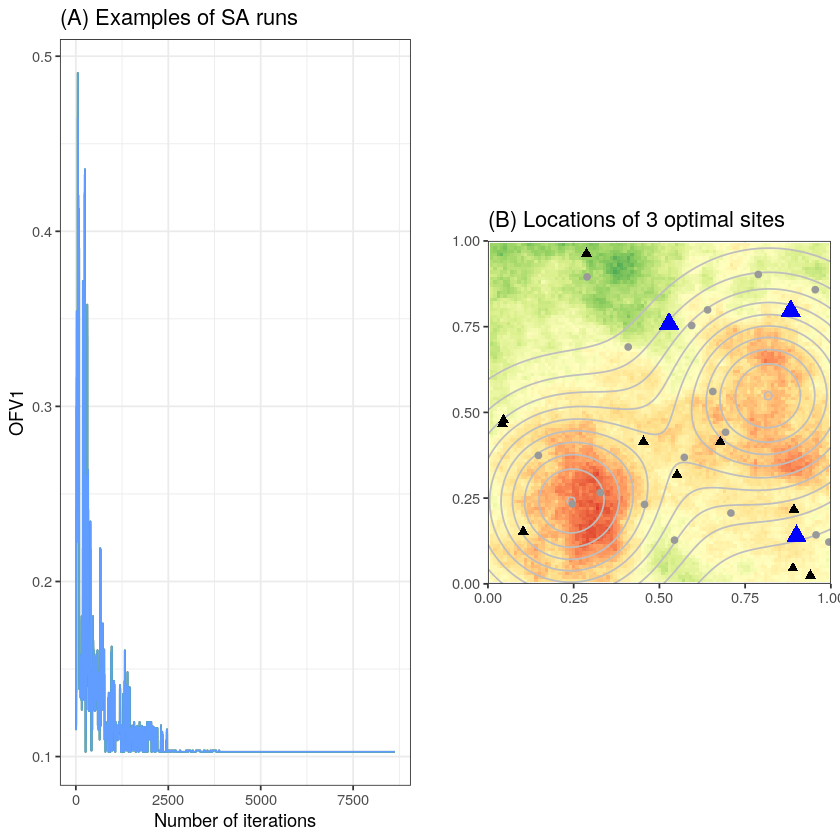

In [144]:
plot_grid(Figure5A, Figure5B)


## End of DIOS_demonstration.R code

## Below... Just collecting session info etc

In [99]:
cat( n.total, n.initial, n.real )

30 10 3

In [115]:
print("")
print("## **==** the end ##--end--##") 
system('date; uptime; hostname; pwd', intern=TRUE)

[1] "## **==** the end ##--end--##"
[1] ""


[1] "Sat 19 Sep 2020 04:56:55 PM PDT" "e23d3172710a"                   
[3] "/mnt/code"

In [146]:
print(system('uptime', intern=TRUE))  

[1] " 14:58:57 up 68 days, 22:21,  0 users,  load average: 0.10, 0.11, 0.59"


In [93]:
print(system('cat /proc/loadavg', intern=TRUE))

[1] "0.08 0.11 0.24 1/1579 3127"


In [101]:
## library(data.table)
fread("cat /proc/loadavg")
fread("cat /proc/loadavg", check.names=TRUE) ## run system command and read result into data frame

V1,V2,V3,V4,V5
<dbl>,<dbl>,<dbl>,<chr>,<int>
0.15,0.11,0.13,1/1580,3134


V1,V2,V3,V4,V5
<dbl>,<dbl>,<dbl>,<chr>,<int>
0.15,0.11,0.13,1/1580,3136


In [147]:
## sessionInfo()

In [106]:
print(warnings())

NULL


## finale